# Setup

In [1]:
!conda info --envs

# conda environments:
#
base                     C:\DDRIVE\ProgramFiles\Anaconda3
earth-analytics-python  *  C:\DDRIVE\ProgramFiles\Anaconda3\envs\earth-analytics-python
envhotzone               C:\DDRIVE\ProgramFiles\Anaconda3\envs\envhotzone
epyf2                    C:\DDRIVE\ProgramFiles\Anaconda3\envs\epyf2
py36                     C:\DDRIVE\ProgramFiles\Anaconda3\envs\py36
wildfire                 C:\DDRIVE\ProgramFiles\Anaconda3\envs\wildfire



In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
import csv
import numpy as np
import os
import sqlite3
import copy
#from dbfread import DBF
import geopandas as gpd
import fiona
import pprint
import folium
#import descartes
import rasterio as rio
from rasterio.plot import plotting_extent
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio import features
import rasterio.mask
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import pickle
from scipy import stats
from rasterio.windows import Window
from numpy import nan
import seaborn as sns

print(f"Python Version = {sys.version}")
print(f"Pandas Version = {pd.__version__}")
print(f"Geopandas Version = {gpd.__version__}")
print(f"rasterio version = {rio._base.gdal_version()}")

Python Version = 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 22:22:21) [MSC v.1916 64 bit (AMD64)]
Pandas Version = 1.0.3
Geopandas Version = 0.7.0
rasterio version = 3.0.4


# Definitions

1) Fine Fuel Moisture Code
The Fine Fuel Moisture Code (FFMC) is a numeric rating of the moisture content of litter and other cured fine fuels. This code is an indicator of the relative ease of ignition and the flammability of fine fuel.

2) Duff Moisture Code
The Duff Moisture Code (DMC) is a numeric rating of the average moisture content of loosely compacted organic layers of moderate depth. This code gives an indication of fuel consumption in moderate duff layers and medium-size woody material.

3) Drought Code
The Drought Code (DC) is a numeric rating of the average moisture content of deep, compact organic layers. This code is a useful indicator of seasonal drought effects on forest fuels and the amount of smoldering in deep duff layers and large logs.

4)  Initial Spread Index
The Initial Spread Index (ISI) is a numeric rating of the expected rate of fire spread. It combines the effects of wind and the FFMC on rate of spread without the influence of variable quantities of fuel.

https://cwfis.cfs.nrcan.gc.ca/background/summary/fwi

5) Temp
Temperature in Celsius degrees

6) RH
Relative humidity in %

7) Wind
Wind speed in km/h

8) Rain
Outside rain in mm/m2

9) Area
The burned area of the forest (in ha), ha = hectare = 2.47 acres

10) X
x-axis spatial coordinate within the Montesinho park map: 1 to 9 2

11) Y
y-axis spatial coordinate within the Montesinho park map: 2 to 9 3

Literature:

https://news.uci.edu/2019/09/17/uci-team-uses-machine-learning-to-help-tell-which-wildfires-will-burn-out-of-control/

In the original paper (Portugal - Montesinho fires), the best result (predicting burned area) was only using the 4 weather conditions: RH/Wind/Rain/Temp, and an SVM.

This: https://datasetsearch.research.google.com/search?query=wildfire%20area&docid=fchFFzqh0O3qjX3PAAAAAA%3D%3D has georeferenced and date/time referenced with areas. Could combine with weather data for those dates/times.

# Query shape of datasets, type, feature names and how they work together

In [4]:
# os.getcwd()

## Fire Data  

In the 'Laura EDA-Geo_Env.ipynb' you can see all the global data. Here we  have only pulled the 2016 California data to do further EDA.

### PRJ file - CRS Descriptions

In [127]:
with open('../data/GlobalFire2016/Global_fire_atlas_V1_ignitions_2016/Global_fire_atlas_V1_ignitions_2016.prj') as f1:
    print(f"Ignitions Prj file contents = {f1.read()}")
    
with open('../data/GlobalFire2016/Global_fire_atlas_V1_perimeter_2016/Global_fire_atlas_V1_perimeter_2016.prj','r') as f2:
    print(f"Perimeter Prj file contents = {f2.read()}")    

Ignitions Prj file contents = GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]]
Perimeter Prj file contents = GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]]


The above mean:
- GEOGCS: Geographic coordinate reference system (vs. a projected coordinate system)
- WGS 84 : the name of the geographic coordinate reference system
- WGS_1984: The name of the DATUM
- SPHEROID: Used for the reference system with the semi major axis = 6378137 m and inverse-flattening ratio of 298.257223563
- PRIMEM: Greenwich is prime meridian where longitude is set as 0
- UNIT: measurement units of coordinate system, in degrees, where 0.01745.. is the conversion from radians to the units here(degrees)

### California - GEOTiffs and GPD Dataframes

Reimport and engineer the features appropriately

First, don't combine the shp files (as in 2.4.2.3). Instead, create 3 dataframes:  
1) fire ID and all the features (except geometry)  
2) fire ID and POLYGON  
3) fire ID and POINT (ignition)  

In [22]:
# %%time
# ign_gdf = gpd.read_file('../data/GlobalFire2016/Global_fire_atlas_V1_ignitions_2016/Global_fire_atlas_V1_ignitions_2016.shp')
# poly_gdf = gpd.read_file('../data/GlobalFire2016/Global_fire_atlas_V1_perimeter_2016/Global_fire_atlas_V1_perimeter_2016.shp')

In [23]:
# # Global Fire Atlas GEOTiff projection Coordinate Reference System (from website)
# gfacrs = "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs" 

#### CA State Boundaries

From https://data.ca.gov/dataset/ca-geographic-boundaries/resource/3db1e426-fb51-44f5-82d5-a54d7c6e188b

In [24]:
# %%time
# CA_gdf = gpd.read_file('../data/ca-state-boundary/CA_state_TIGER2016.shp')

In [25]:
# CA_gdf

In [26]:
# CA_gdf.plot()

#### Crop rasters to California

From Earth  data science: https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/raster-data-processing/crop-raster-data-with-shapefile-in-python/

In [27]:
# # Raster Data opened by rio is diryr
# print(diryr.bounds)

In [28]:
# # Crop extent: CA_gdf
# print('crop extent crs = \n', CA_gdf.crs)
# print('tiff crs = \n', diryr.crs)

In [29]:
# # Set destination CRS
# dst_crs = CA_gdf.crs

In [30]:
# %%time
# # Calculate the transform using the rasterio warp function
# transform,width,height = calculate_default_transform(diryr.crs,dst_crs,diryr.width,diryr.height,*diryr.bounds)

In [31]:
# %%time
# # Set the new meta data for the projected raster file
# kwargs = diryr.meta.copy()
# kwargs.update({'crs':dst_crs,
#               'transform':transform,
#               'width':width,
#               'height':height
#               })

In [32]:
# %%time
# # write the new raster file by using the rasterio reproject function
# with rio.open('../data/GlobalFire2016/Global_fire_atlas_direction_yearly_2016_reproj.tif','w',**kwargs) as dst:
#     for i in range(1, diryr.count + 1):
#         reproject(
#             source = rio.band(diryr,i),
#             destination=rio.band(dst,i),
#             diryr_transform = diryr.transform,
#             diryr_crs = diryr.crs,
#             dst_transform = transform,
#             dst_crs = dst_crs,
#             resampling=Resampling.nearest)

In [33]:
# %%time
# # Open the new reprojected geotiff
# diryr_reproj = rio.open('../data/GlobalFire2016/Global_fire_atlas_direction_yearly_2016_reproj.tif')
# print(diryr_reproj.meta)

In [34]:
# %%time
# # Crop extent: CA_gdf - crop to the boundaries of California, which should work now that both raster 
# # and shapefile are on the same CRS
# print('crop extent crs = \n', CA_gdf.crs)
# print('tiff crs = \n', diryr_reproj.crs)

In [35]:
# %%time
# # Use the earthpy.spatial function to crop the tif by the shapefile
# diryr_reproj_crop, diryr_reproj_crop_meta = es.crop_image(diryr_reproj,CA_gdf)

In [36]:
# print("cropped data", diryr_reproj_crop.shape)
# print("original data", diryr.shape)

In [37]:
# # Use the affine transformation for the CRS to define the extents
# diryr_reproj_crop_affine = diryr_reproj_crop_meta["transform"]
# diryr_reproj_extent = plotting_extent(diryr_reproj_crop[0],diryr_reproj_crop_affine)

In [38]:
# diryr_reproj_crop_meta

In [39]:
# fig,ax = plt.subplots(figsize=(10,16))
# ep.plot_bands(diryr_reproj_crop,
#               extent = diryr_reproj_extent,
#               cmap='Greys',
#               title = 'Direction',
#               scale=False,
#               ax=ax,
#               cbar=False)

# CA_gdf.plot(ax=ax,alpha=0.2)
# ax.set_axis_off()
# plt.show()

In [40]:
# vals = diryr_reproj_crop[0][diryr_reproj_crop[0]>0]
# vals

In [41]:
# print(type(vals),vals.shape)
# stats.describe(vals)

##### Transform Ignition and polygons of final fire sizes to CA CRS

In [42]:
# # transform CRS
# ign2 = ign_gdf.to_crs(dst_crs)
# poly2 = poly_gdf.to_crs(dst_crs)

In [43]:
# # set area to crop to
# bb = CA_gdf.envelope

In [44]:
# # Crop polygons of final fire sizes using geopandas overlay
# df2 = gpd.GeoDataFrame(gpd.GeoSeries(bb),columns=['geometry'])
# poly2crop = gpd.overlay(df2,poly2,how='intersection')

In [45]:
# # Use dataframe slicing for the ignition point data.
# xmin,ymin,xmax,ymax=CA_gdf.total_bounds
# ign2crop = ign2.cx[xmin:xmax,ymin:ymax]

In [46]:
# fig,ax = plt.subplots(figsize=(10,16))
# ep.plot_bands(diryr_reproj_crop,
#               extent = diryr_reproj_extent,
#               cmap='Greys',
#               title = 'Direction',
#               scale=False,
#               ax=ax,
#               cbar=False)

# CA_gdf.plot(ax=ax, alpha=0.2)
# ign2crop.plot(ax=ax,marker='x',color='green',markersize=12)
# poly2crop.plot(ax=ax,alpha=0.4)
# ax.set_axis_off()
# plt.show()

#### Create new bounding box for smaller section of CA and convert CRS
Repeat above process for cropping

In [47]:
# # Set source CRS - this is the google maps CRS
# bb_gdf_orig.crs = {'init':'epsg:4326'}
# print(bb_gdf_orig.crs)

In [48]:
# # Create bounding box polygon from lat long pulled from Gmaps
# from shapely.geometry import Polygon
# bb_long = [-122, -119.912,-119.912,-122,-122 ]
# bb_lat = [36.8, 36.8, 35.06, 35.06,36.8]
# bb_poly = Polygon(zip(bb_long,bb_lat))
# bb_gdf2 = gpd.GeoDataFrame(index=[0],crs=bb_gdf_orig.crs,geometry = [bb_poly])
# print(bb_gdf2.geometry)

In [49]:
# # Change CRS of polygon to match other work here
# bb_gdf2 = bb_gdf2.to_crs(epsg=3857)
# bb_gdf2

In [50]:
# # Plotting
# fig,ax = plt.subplots(figsize=(10,16))
# ep.plot_bands(diryr_reproj_crop,
#               extent = diryr_reproj_extent,
#               cmap='Greys',
#               title = 'Direction',
#               scale=False,
#               ax=ax,
#               cbar=False)

# CA_gdf.plot(ax=ax, alpha=0.2)
# ign2crop.plot(ax=ax,marker='x',color='green',markersize=12)
# poly2crop.plot(ax=ax,alpha=0.4)
# bb_gdf2.plot(ax=ax,color='green',alpha=0.2)
# ax.set_axis_off()
# plt.show()

#### Convert CRS for remaining raster files

In [51]:
# # Raster Data opened by rio 
# #speedyr = rio.open('../data/GlobalFire2016/Global_fire_atlas_speed_yearly_2016.tif')
# #dobyr = rio.open('../data/GlobalFire2016/Global_fire_atlas_day_of_burn_yearly_2016.tif')
# #firelineyr = rio.open('../data/GlobalFire2016/Global_fire_atlas_fire_line_yearly_2016.tif')
# print('speedyr bounds =',speedyr.bounds)
# print('dobyr bounds =',dobyr.bounds)
# print('firelineyr bounds =',firelineyr.bounds)

In [52]:
# # Set destination CRS
# dst_crs = bb_gdf2.crs

In [53]:
# tifs = [(speedyr,'speed'),(dobyr,'dob'),(firelineyr,'fireline')]

In [54]:
# Commented out this whole box because files have been saved already NEXT TIME - ADD COMPRESSION - 
# FILES WERE HUGE (see commented line below) OR reproject to new array, then write out with compression
# %%time
# for tif in tifs:
#     file,name = tif
    
#     # Calculate the transform using the rasterio warp function
#     transform,width,height = calculate_default_transform(file.crs,dst_crs,file.width,file.height,*file.bounds)
    
#     # Set the new meta data for the projected raster file
#     kwargs = file.meta.copy()
#     kwargs.update({'crs':dst_crs,
#                   'transform':transform,
#                   'width':width,
#                   'height':height
#                   #compress:'lzw'
#                   })
    
#     # Filename for writing out to
#     filestring = '../data/GlobalFire2016/Global_fire_atlas_' + name + '_yearly_2016_reproj.tif'
    
#     # write the new raster file by using the rasterio reproject function
#     with rio.open(filestring,'w',**kwargs) as dst:
#         for i in range(1, file.count + 1):
#             reproject(
#                 source = rio.band(file,i),
#                 destination=rio.band(dst,i),
#                 file_transform = file.transform,
#                 file_crs = file.crs,
#                 dst_transform = transform,
#                 dst_crs = dst_crs,
#                 resampling=Resampling.nearest)  

In [55]:
# # Close all the previous readers
# diryr.close()
# dobyr.close()
# firelineyr.close()
# speedyr.close()

#### Crop to smaller bounding box - Toy Set

In [56]:
# # Check CRSs all match
# print('ignition CRS', ign2.crs)
# print('final polygon CRS', poly2.crs)
# print('bounding box CRS', bb_gdf2.crs)

##### First the ignition points to get fire numbers and then final fire sizes and dbf data

In [57]:
# print('bounding box extents', bb_gdf2.total_bounds)

In [58]:
# # Crop Ignition Data
# xmin2,ymin2,xmax2,ymax2=bb_gdf2.total_bounds
# ign2crop2 = ign2.cx[xmin2:xmax2,ymin2:ymax2]

In [59]:
# print(ign2crop2.shape, ign2.shape)

In [60]:
# fires = ign2crop2['fire_ID'].values

In [61]:
# poly2crop2 = poly2.loc[poly2['fire_ID'].isin(fires)]

In [62]:
# print(poly2crop2.shape, poly2.shape)

In [63]:
# featurescrop2 = features1.loc[features1['fire_ID'].isin(fires)]

In [64]:
# featurescrop2.head()

In [65]:
# ign2crop2.head()

In [66]:
# %%time
# #pickle out the ignition points and dbf
# with open('../data/GlobalFire2016/Global_fire_atlas_ignitioncrop.pickle','wb') as f:
#     pickle.dump(ign2crop2,f,pickle.HIGHEST_PROTOCOL)
# with open('../data/GlobalFire2016/Global_fire_atlas_datacrop.pickle','wb') as f:
#     pickle.dump(featurescrop2,f,pickle.HIGHEST_PROTOCOL)

##### Crop the rasters

In [67]:
# # Open the new reprojected geotiffs
# diryr_reproj = rio.open('../data/GlobalFire2016/Global_fire_atlas_direction_yearly_2016_reproj.tif')
# speedyr_reproj = rio.open('../data/GlobalFire2016/Global_fire_atlas_speed_yearly_2016_reproj.tif')
# dobyr_reproj = rio.open('../data/GlobalFire2016/Global_fire_atlas_dob_yearly_2016_reproj.tif')
# firelineyr_reproj = rio.open('../data/GlobalFire2016/Global_fire_atlas_fireline_yearly_2016_reproj.tif')

In [68]:
# # Crop extent: bb_gdf2 - crop to the small box, which should work now that both raster 
# # and shapefile are on the same CRS
# print('crop extent crs = ', bb_gdf2.crs)
# print('direction tiff crs = ', diryr_reproj.crs)
# print('speed tiff crs = ', speedyr_reproj.crs)
# print('day of burn tiff crs = ', dobyr_reproj.crs)
# print('fireline tiff crs = ', firelineyr_reproj.crs)

In [69]:
# def crop_tif(tif_reproj,boundingbox):
#     """function to crop the reprojected tiffs by the bounding box (shapefile)"""
    
#     tif_reproj_crop,tif_reproj_crop_meta = es.crop_image(tif_reproj,boundingbox)
#     print("cropped data", tif_reproj_crop.shape)
#     print("original data", tif_reproj.shape)
#     print("meta", tif_reproj_crop_meta)
       
#     return(tif_reproj_crop, tif_reproj_crop_meta)

In [70]:
# %%time
# diryr_reproj_crop,diryr_reproj_crop_meta = crop_tif(diryr_reproj,bb_gdf2)
# speedyr_reproj_crop,speedyr_reproj_crop_meta = crop_tif(speedyr_reproj,bb_gdf2)
# dobyr_reproj_crop,dobyr_reproj_crop_meta = crop_tif(dobyr_reproj,bb_gdf2)
# firelineyr_reproj_crop,firelineyr_reproj_crop_meta = crop_tif(firelineyr_reproj,bb_gdf2)

In [71]:
# vals = firelineyr_reproj_crop[0][firelineyr_reproj_crop[0]>0]
# vals

In [72]:
# diryr_reproj.close()
# speedyr_reproj.close()
# dobyr_reproj.close()
# firelineyr_reproj.close()

In [73]:
# # Write these out to smaller tiffs
# with rio.open('../data/GlobalFire2016/Global_fire_atlas_dircrop.tif','w',**diryr_reproj_crop_meta) as dst:
#     dst.write(diryr_reproj_crop)
# with rio.open('../data/GlobalFire2016/Global_fire_atlas_speedcrop.tif','w',**speedyr_reproj_crop_meta) as dst:
#     dst.write(speedyr_reproj_crop)
# with rio.open('../data/GlobalFire2016/Global_fire_atlas_dobcrop.tif','w',**dobyr_reproj_crop_meta) as dst:
#     dst.write(dobyr_reproj_crop)
# with rio.open('../data/GlobalFire2016/Global_fire_atlas_firelinecrop.tif','w',**firelineyr_reproj_crop_meta) as dst:
#     dst.write(firelineyr_reproj_crop)

#### Create a new tiff with fire_ID as the value
Determine if a raster pixel is in a fire polygon and create a new tiff with fire_ID as the value

In [74]:
# # From https://gis.stackexchange.com/questions/151339/rasterize-a-shapefile-with-geopandas-or-fiona-python
# polys = poly2crop2
# rst_fn = '../data/GlobalFire2016/template.tif'
# out_fn = '../data/GlobalFire2016/fireid.tif'

In [75]:
# rst = rio.open(rst_fn)
# metaout = rst.meta.copy()
# metaout.update(compress='lzw')

In [76]:
# with rio.open(out_fn, 'w+',**metaout) as out:
#     out_arr = out.read(1)
    
#     shapes = ((geom,value) for geom,value in zip(polys.geometry,polys.fire_ID))
    
#     burned = features.rasterize(shapes=shapes, fill=0, out=out_arr, transform=out.transform)
#     out.write_band(1,burned)

In [77]:
# fireid = rio.open('../data/GlobalFire2016/fireid.tif')
# print(fireid.meta)

In [78]:
# fireid_array = fireid.read()

In [79]:
# fireid_array.shape

In [80]:
# print(fireid_array)

In [81]:
# vals = fireid_array[0][fireid_array[0]>0]
# vals

In [82]:
# len(vals)

#### Yearly TIFFs

In [83]:
# from rasterio.windows import Window

In [84]:
# %%time
# diryr = rio.open('../data/GlobalFire2016/Global_fire_atlas_direction_yearly_2016.tif')
# speedyr = rio.open('../data/GlobalFire2016/Global_fire_atlas_speed_yearly_2016.tif')
# dobyr = rio.open('../data/GlobalFire2016/Global_fire_atlas_day_of_burn_yearly_2016.tif')
# firelineyr = rio.open('../data/GlobalFire2016/Global_fire_atlas_fire_line_yearly_2016.tif')

In [85]:
# tifs = [diryr,speedyr,dobyr,firelineyr]

In [86]:
# for tif in tifs:
#     print("name = ",tif.name)
#     print("resolution of a pixel in units of coord reference system = ",tif.res)
#     print("Image Structure tags =",tif.tags(ns='IMAGE_STRUCTURE'))
#     print("tags =",tif.tags())
#     print(tif.shape)
#     print(tif.bounds)
#     print("number of layers = ",tif.count)
#     print("number of bands =", tif.indexes)
#     print(tif.meta)
#     print("\n\n")

In [87]:
# print(diryr.meta)
# #customcrs = diryr.meta

In [88]:
# print(diryr.crs)

In [89]:
# customcrs = diryr.crs

#### Convert Lat/Long to CRS

From StackExchange:

You need to transform your points to the coordinate system of the raster. You could warp the raster to your points' coordinate system but warping rasters is a bit messy. (for R but should be similar in python)

https://gis.stackexchange.com/questions/200417/very-basic-question-on-extracting-data-from-tif-raster-layer-in-r-projection-n

In [90]:
# # Our desired 'fire' from the shapefile
# fire

In [91]:
# fire.crs

In [92]:
# # Global Fire Atlas projection Coordinate Reference System (from website)
# gfacrs = "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs" 

In [93]:
# fire2 = fire.to_crs(gfacrs)
# fire2

In [94]:
# fire2.geometry.name

In [95]:
# fire2.crs  # Ah that is why you can't convert two columns. because when you convert one column
# # then the entire dataframe thinks it is now in the new CRS

# EDA Stats and Plots

## Raster Data

In [5]:
# Opening the 4 raster files in toy data (not including DOB)
with rio.open('../toydata/Global_fire_atlas_dircrop.tif') as f1:
    direction = f1.read(1).astype(float)
with rio.open('../toydata/Global_fire_atlas_firelinecrop.tif') as f2:
    fireline = f2.read(1).astype(float)
with rio.open('../toydata/Global_fire_atlas_speedcrop.tif') as f3:
    speed = f3.read(1)
with rio.open('../toydata/fireid.tif') as f4:
    fireid = f4.read(1).astype(float)

In [6]:
rasters = {'direction':direction,'fireline':fireline,'speed':speed,'fireid':fireid}

In [7]:
fireline

array([[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       ...,
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.]])

In [8]:
from collections import Counter
# from osgeo import gdal_array

In [9]:
print(Counter(fireline.flatten()))

Counter({-9999.0: 210776, 209.0: 144, 236.0: 138, 230.0: 111, 234.0: 106, 235.0: 106, 210.0: 93, 211.0: 92, 233.0: 88, 207.0: 87, 216.0: 85, 218.0: 83, 262.0: 82, 222.0: 81, 206.0: 80, 205.0: 80, 223.0: 79, 221.0: 77, 229.0: 77, 263.0: 75, 231.0: 75, 219.0: 74, 213.0: 72, 220.0: 68, 228.0: 63, 144.0: 61, 217.0: 60, 237.0: 60, 224.0: 56, 232.0: 52, 227.0: 52, 212.0: 49, 265.0: 47, 225.0: 43, 242.0: 43, 238.0: 41, 257.0: 40, 248.0: 38, 264.0: 37, 226.0: 36, 208.0: 35, 247.0: 34, 267.0: 32, 261.0: 32, 215.0: 30, 239.0: 30, 255.0: 29, 157.0: 29, 142.0: 28, 214.0: 26, 184.0: 26, 241.0: 25, 243.0: 24, 246.0: 23, 251.0: 21, 240.0: 19, 250.0: 19, 140.0: 19, 266.0: 18, 146.0: 17, 249.0: 17, 259.0: 16, 155.0: 13, 100.0: 12, 300.0: 12, 254.0: 11, 253.0: 11, 269.0: 10, 252.0: 9, 159.0: 9, 256.0: 7, 156.0: 7, 105.0: 6, 268.0: 6, 270.0: 6, 143.0: 6, 260.0: 5, 245.0: 4, 145.0: 3, 244.0: 3, 161.0: 3, 204.0: 2, 273.0: 2, 304.0: 2, 297.0: 2, 148.0: 2, 203.0: 1, 147.0: 1, 271.0: 1, 299.0: 1, 301.0: 1, 16

In [10]:
fireline.shape

(470, 456)

Of the 214,320 pixels, 210,776 contain null values.  That roughly means 1.65% of the raster file has any fire data.  

In [11]:
print(Counter(direction.flatten()))

Counter({-9999.0: 209491, 4.0: 1383, 8.0: 1084, 3.0: 841, 7.0: 540, 5.0: 539, 1.0: 442})


In [12]:
print(Counter(speed.flatten()))

Counter({-9999.0: 209465, 0.46: 675, 0.74: 487, 0.75: 223, 0.93: 153, 1.49: 145, 0.48: 141, 1.14: 126, 1.61: 106, 1.47: 105, 1.89: 86, 1.87: 63, 1.22: 57, 1.13: 55, 0.94: 51, 2.29: 46, 1.15: 42, 3.03: 37, 2.63: 36, 2.21: 35, 0.96: 34, 2.07: 34, 1.6: 33, 1.62: 32, 2.23: 31, 1.39: 29, 3.33: 26, 2.75: 26, 1.88: 26, 1.43: 25, 1.91: 23, 1.85: 23, 4.63: 22, 2.98: 22, 5.6: 22, 9.03: 22, 1.41: 21, 2.64: 20, 6.2: 19, 2.37: 19, 2.71: 19, 4.06: 19, 7.16: 18, 2.35: 18, 2.84: 18, 3.0: 18, 7.34: 18, 3.4: 18, 4.14: 17, 3.38: 17, 2.83: 17, 9.13: 17, 9.39: 17, 2.76: 16, 3.78: 16, 1.9: 16, 2.44: 16, 2.53: 16, 3.59: 16, 3.31: 15, 6.79: 15, 2.97: 15, 5.11: 15, 2.38: 15, 0.95: 15, 4.25: 14, 3.04: 14, 6.12: 14, 3.09: 14, 3.01: 14, 3.49: 14, 1.21: 14, 4.16: 14, 6.01: 14, 3.32: 13, 3.22: 13, 2.8: 13, 1.42: 13, 2.81: 13, 3.44: 12, 5.1: 12, 4.21: 12, 4.18: 12, 3.45: 12, 1.4: 12, 1.95: 12, 1.97: 11, 2.54: 11, 4.43: 11, 4.26: 11, 2.92: 11, 7.08: 11, 3.43: 11, 3.77: 11, 2.33: 11, 2.28: 11, 2.34: 11, 3.42: 11, 2.27

In [13]:
print(Counter(fireid.flatten()))

Counter({-9999.0: 209465, 140.0: 2674, 189.0: 1126, 142.0: 240, 141.0: 137, 161.0: 123, 143.0: 114, 185.0: 107, 147.0: 72, 167.0: 54, 164.0: 42, 165.0: 37, 162.0: 31, 170.0: 20, 163.0: 18, 166.0: 18, 190.0: 18, 146.0: 12, 171.0: 5, 148.0: 4, 178.0: 1, 184.0: 1, 188.0: 1})


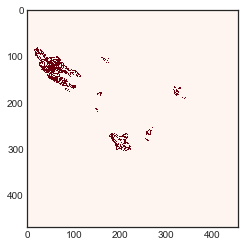

In [134]:
# plt.figure()
# plt.imshow(fireline, cmap='Reds')    
# plt.show()

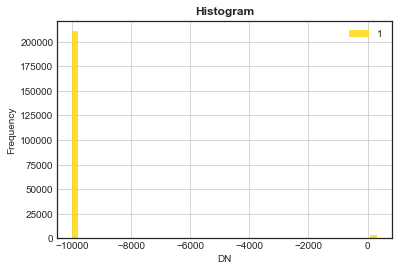

In [136]:
# from rasterio.plot import show_hist

# show_hist(fireline, bins=50, lw=0.0, stacked=False, alpha=0.8, histtype='stepfilled', title="Histogram")

### Fire Data Heatmaps

In [15]:
def plot_rasters(rasters):
    """ Plot all the fire data rasters for 2016 as heatmaps"""
    fig = plt.figure(figsize = (20,4))
    fig.suptitle('Bounded Fire Data showing Sparsity 2016')
    fig.subplots_adjust(hspace=0.4)
    i=1
    for key,data in rasters.items():
        ax = fig.add_subplot(1,4,i)
        sns.heatmap(data)
        ax.set_title(key)
        i+=1
    plt.savefig('HeatmapFireData.jpg', dpi=300)
    plt.show()

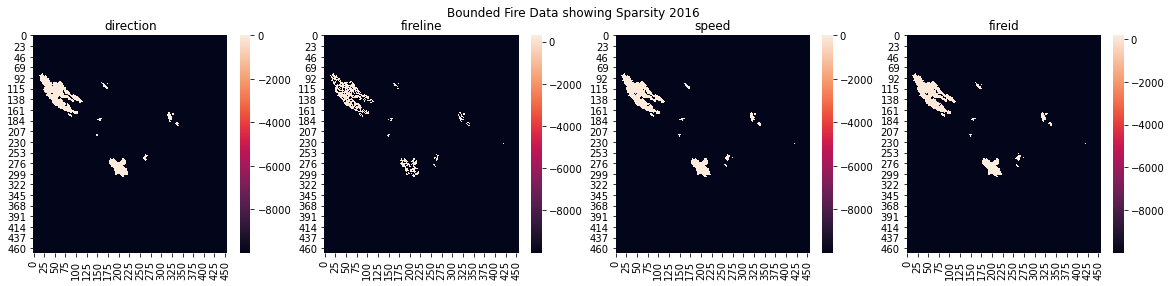

In [16]:
# Visual of sparsity
plot_rasters(rasters)

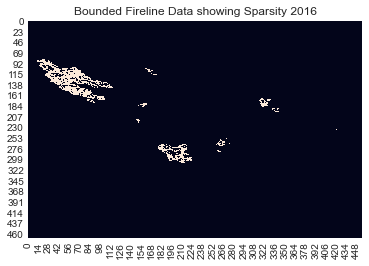

In [23]:
plt.title('Bounded Fireline Data showing Sparsity 2016')
sns.heatmap(fireline,cbar=None)
plt.savefig('HeatmapFirelineData.jpg', dpi=300)
plt.show()

### Fire Data Statistics

In [19]:
# First create 1D array from 2D rasters
dir1 = copy.deepcopy(direction)
fl1 = copy.deepcopy(fireline)
spd1 = copy.deepcopy(speed)
fid1 = copy.deepcopy(fireid)

In [20]:
dir1 = np.ravel(dir1)
fl1 = np.ravel(fl1)
spd1 = np.ravel(spd1)
fid1 = np.ravel(fid1)

In [102]:
onedim = {'direction':dir1,'fireline':fl1,'speed':spd1,'fireid':fid1}

In [103]:
totalpixels = dir1.shape[0]

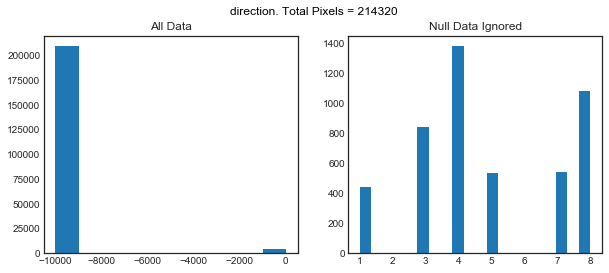

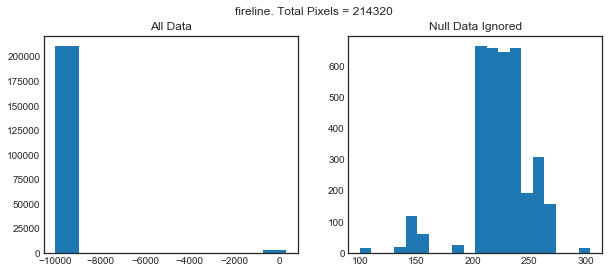

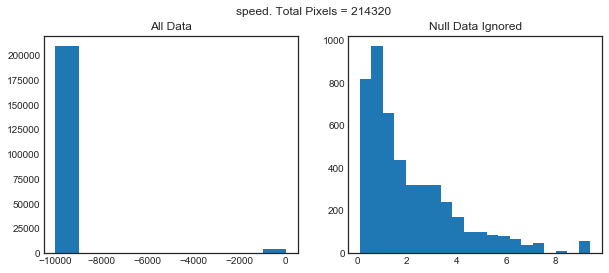

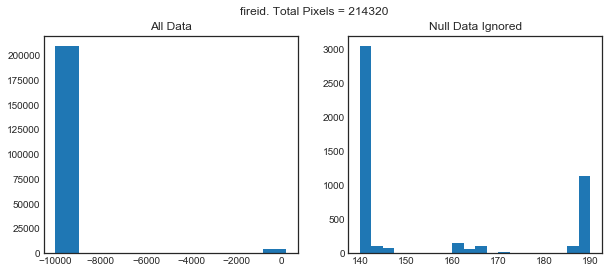

In [104]:
for name,data in onedim.items():
    fig = plt.figure(figsize = (10,4))
    fig.suptitle(f"{name}. Total Pixels = {totalpixels}")
    plt.style.use('seaborn-white')
    ax = fig.add_subplot(1,2,1)
    plt.hist(data)
    ax.set_title("All Data")
    ax = fig.add_subplot(1,2,2)
    plt.hist(data[data>-10],bins=20)
    ax.set_title("Null Data Ignored")
    plt.show()

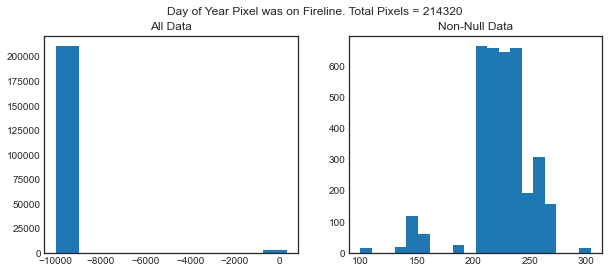

In [24]:
fig = plt.figure(figsize = (10,4))
fig.suptitle(f"Day of Year Pixel was on Fireline. Total Pixels = {fl1.shape[0]}")
plt.style.use('seaborn-white')
ax = fig.add_subplot(1,2,1)
plt.hist(fl1)
ax.set_title("All Data")
ax = fig.add_subplot(1,2,2)
plt.hist(fl1[fl1>-10],bins=20)
ax.set_title("Non-Null Data")
plt.savefig('FirelineHist.jpg',dpi=300)
plt.show()

# Setup